In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Pytorch Imagefolder for loading data

In [ ]:
dataset_path = '/content/drive/MyDrive/PRML Project/covid 19/Extensive COVID-19 X-Ray and CT Chest Images Dataset.zip (Unzipped Files)/COVID-19 Dataset.zip (Unzipped Files)/COVID-19 Dataset/X-ray'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
from torchvision.transforms.transforms import RandomHorizontalFlip
dataset_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [ ]:
dataset = torchvision.datasets.ImageFolder(root = dataset_path, transform = dataset_transforms)

KeyboardInterrupt: ignored

In [ ]:
dataset[0][0].shape

In [ ]:
torchvision.transforms.Grayscale()(dataset[0][0]).shape

In [ ]:
plt.imshow(dataset[0][0].permute(1, 2, 0), interpolation='bicubic')

In [ ]:
plt.imshow(transforms.ToPILImage()(dataset[0][0]), interpolation="bicubic")

In [ ]:
len(dataset)

In [ ]:
def split_XY(dataset):
    l = []
    a = torch.Tensor(len(dataset), 1, 224, 224)
    for i, (image, label) in enumerate(dataset):
        # a[i, :, :, :] = image
        a[i, :, :, :] = torchvision.transforms.Grayscale()(image)
        l.append(label)
    return a, torch.Tensor(l)
X, y = split_XY(dataset)

In [ ]:
cuda = torch.device('cuda')

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
X = torch.Tensor(X).to(cuda)

In [ ]:
X.shape[2]

In [ ]:
X1 = torch.reshape(X, (X.shape[0], X.shape[2]*X.shape[3]))

In [ ]:
X1.shape

In [ ]:
y = y.to(cuda)

# PCA of pytorch

In [ ]:
m = X1.mean(0, keepdim=True)
s = X1.std(0, unbiased=False, keepdim=True)
X1 -= m
X1 /= s

In [ ]:
X1.shape

In [ ]:
U, S, V = torch.pca_lowrank(X1, q=min(X1.shape[0], X1.shape[1]), center = True, niter = 100)

In [ ]:
S.shape

In [ ]:
eigenvalues = S

In [ ]:
eigenval = eigenvalues.cpu().detach().numpy()

In [ ]:
loaded_vals = eigenval/eigenval.sum() 

In [ ]:
loaded_vals[:2114].sum()

In [ ]:
np.array([i for i in range(1,2115)]).shape

In [ ]:
loaded_vals.shape

In [ ]:
plt.bar([i for i in range(1,2115)], loaded_vals[:2114])

In [ ]:
S

In [ ]:
eigenvectors = V

In [ ]:
indexsort = torch.argsort(S, descending=True)

In [ ]:
indexsort

In [ ]:
sorteigenvalue = eigenvalues[indexsort]

In [ ]:
sorteigenvectors = eigenvectors[:, indexsort]

In [ ]:
sorteigenvectors.shape

In [ ]:
X1.shape

In [ ]:
eigenvectorsubset = sorteigenvectors[:, :2114]

In [ ]:
eigenvectorsubset.shape

In [ ]:
pca_x = torch.matmul(X1, eigenvectorsubset)

In [ ]:
pd.DataFrame(pca_x.cpu().detach().numpy())

In [ ]:
pca_x.shape

## Kmeans sklearn on PCA pytorch

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
pca_x_np = pca_x.cpu().detach().numpy()

In [ ]:
pca_x_np.shape

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(pca_x_np)

In [ ]:
y_pred_np = kmeans.labels_

In [ ]:
y_pred_np

In [ ]:
y_true = y.cpu().detach().numpy()

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm_matrix2 = pd.DataFrame(data = confusion_matrix(pd.Series(y_true, dtype=int), pd.Series(y_pred_np)), columns = ['Actual Positive', 'Actual Negative'], index = ['Predicted Positive', 'Predict Negative'])
sns.heatmap(cm_matrix2, annot=True, fmt='d').set(title='CM for Kmeans')

Evaluation Metrics on preserving 98% variance:

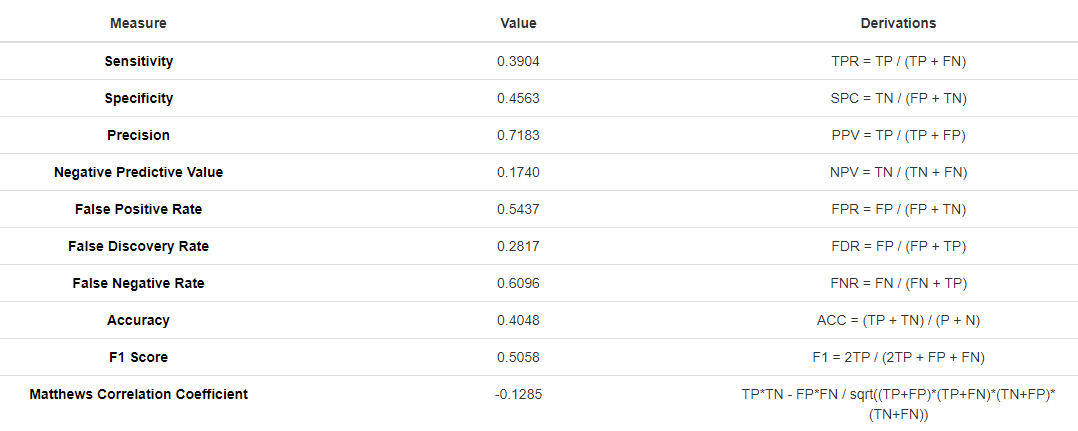

# Sklearn Agglomerative Clustering on pca_x_np (dimensionally reduced dataframe of pca_lowrank())

In [ ]:
from sklearn.cluster import AgglomerativeClustering as AC
aggcluster1=AC(n_clusters=2).fit_predict(pca_x_np)

In [ ]:
pca_x_np.shape

In [ ]:
cm_matrix3 = pd.DataFrame(data = confusion_matrix(pd.Series(y_true, dtype=int), pd.Series(aggcluster1)), columns = ['Actual Positive', 'Actual Negative'], index = ['Predicted Positive', 'Predict Negative'])
sns.heatmap(cm_matrix3, annot=True, fmt='d').set(title='CM for Agglomerative Clustering')

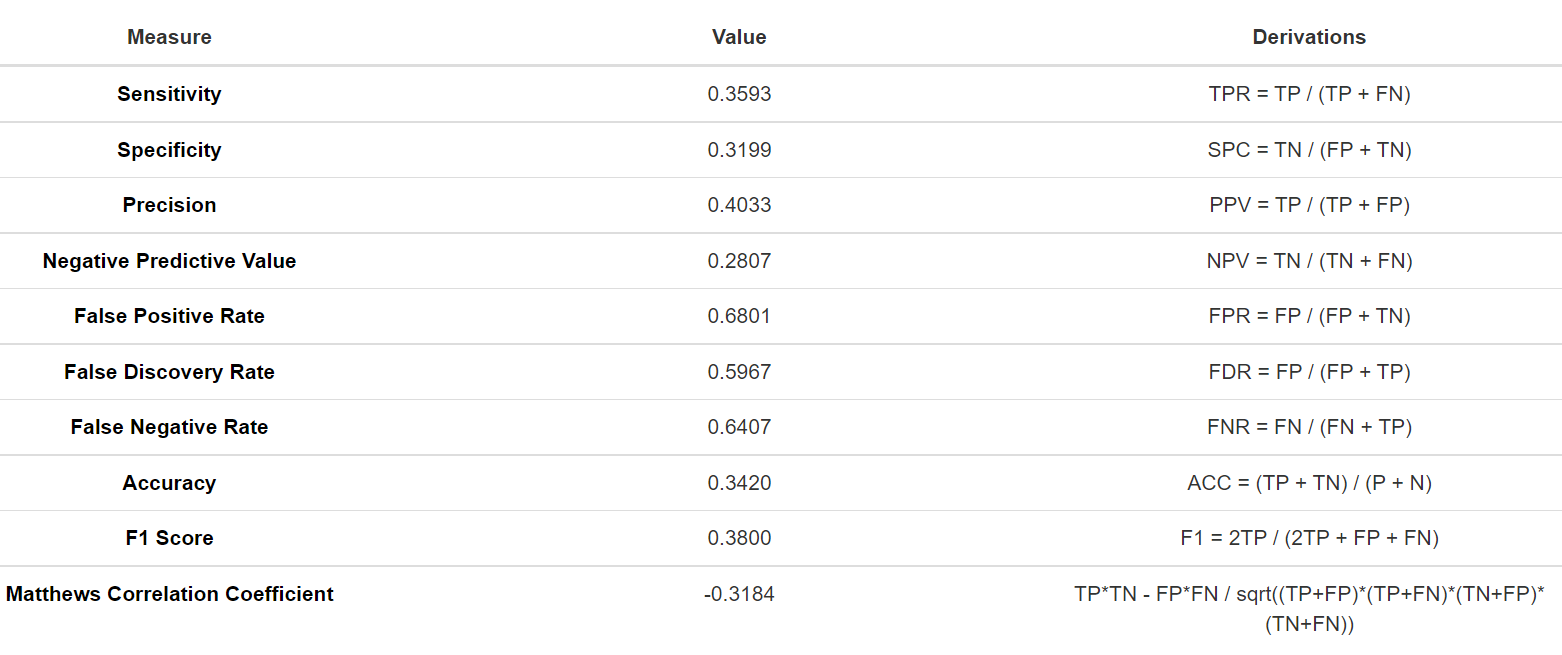

# Sklearn Agglomerative Clustering on X1_np (full dataframe)

In [ ]:
from sklearn.cluster import AgglomerativeClustering as AC
aggcluster3=AC(n_clusters=2).fit_predict(X1_np)

In [ ]:
X1_np.shape

In [ ]:
cm_matrix3 = pd.DataFrame(data = confusion_matrix(pd.Series(y_true, dtype=int), pd.Series(aggcluster3)), columns = ['Actual Positive', 'Actual Negative'], index = ['Predicted Positive', 'Predict Negative'])
sns.heatmap(cm_matrix3, annot=True, fmt='d').set(title='CM for Agglomerative Clustering')

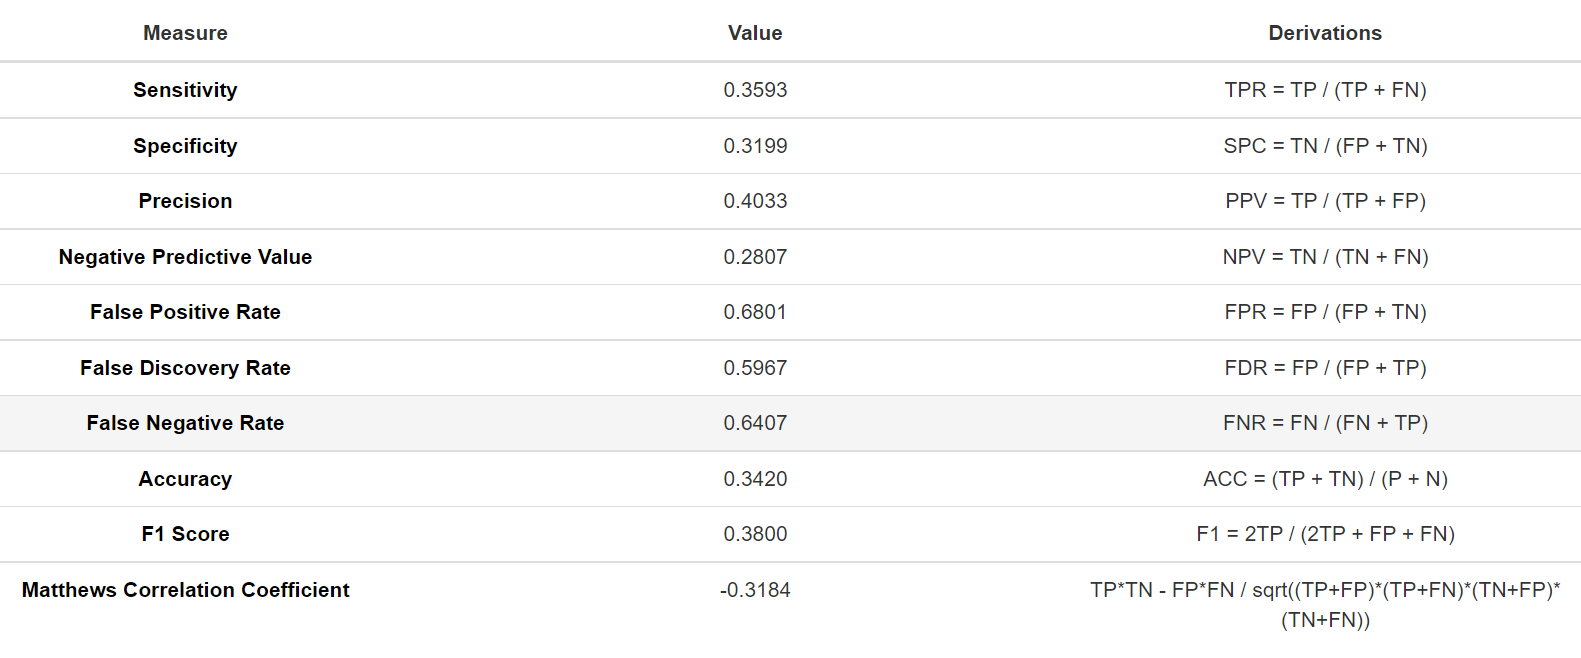

Agglomerative Clustering Analysis through Clustimage library

In [ ]:
!pip install clustimage

In [ ]:
from clustimage import Clustimage

In [ ]:
cl = Clustimage(method='pca', grayscale=True)

In [ ]:
Xda = cl.import_data(X1_np)

In [ ]:
Xfeat = cl.extract_feat(Xda)

In [ ]:
xycoord = cl.embedding(Xfeat)

In [ ]:
labels = cl.cluster(cluster='agglomerative',
                    evaluate='silhouette',
                    metric='euclidean',
                    linkage='ward',
                    min_clust=3,
                    max_clust=25,
                    cluster_space='high')

In [ ]:
# Return
results = cl.results

In [ ]:
# Results are stored as a dictionary:
cl.results.keys()

# 'feat'      : Extracted features.
# 'xycoord'   : The X and Y coordinates from tSNE embedding
# 'pathnames' : The path locations of the processed images
# 'filenames' : The filename of the image
# 'labels'    : The cluster labels

In [ ]:
# Silhouette plots
cl.clusteval.plot()
cl.clusteval.scatter(cl.results['xycoord'])

# PCA explained variance plot
cl.pca.plot()

# Dendrogram
cl.dendrogram()

# Plot unique image per cluster
cl.plot_unique(img_mean=False)

# Scatterplot
cl.scatter(zoom=3, img_mean=False)
cl.scatter(zoom=None, img_mean=False)

# Plot images per cluster or all clusters
cl.plot(cmap='binary', labels=[1,2])
cl.plot(cmap='binary')